# Exercise - Regression and model misspecification

## Introduction

This exercise has two goals:
* To give you practice with StanFitter and the Stan language;
* To build your understanding of (linear) regression (estimating a *conditional expectation*) and conditional independence.

### PyStan and StanFitter

PyStan is typically used by importing the `pystan` module and using the `pystan.stan()` function to compile and fit a model via posterior sampling.  The PyStan test script you used to test your installation, described in lab, provides an example; a copy is included with this assignment as "PyStanNormNormTest.py".  It implements the normal-normal conjugate model.

For your assignments, you will instead use the `StanFitter` class to access PyStan; it is defined in the `stanfitter.py` module provided with this assignment.  `StanFitter` is the only object you need from that module. You won't be modifying any `stanfitter.py` code, and you do not need to study the code, which relies on some undocumented or poorly documented parts of PyStan.

Last week's lab included a simple example of `StanFitter` use, treating estimation of a normal mean using a conjugate prior. This exercise demonstrates using `Stan` via `StanFitter` for straight-line regression problems.

The `stanfitter` module provides the following helpful capabilities:
* For Windows users, it **handles some Windows requirements** for you (particularly, turning off support for parallel computation; earlier versions handled some more complicated Windows requirements).
* `StanFitter` **caches a Stan model** when it is compiled. Future runs of Python code that use that model will not have to execute the compilation step at runtime. This is especially useful for shortening debug time when you are revising non-Stan code in your notebooks and scripts.
* `StanFitter` provides Stan fit results via an instance of `StanFitResults`, a container class that **provides more "Pythonic" access to fit results** than Stan's native interface, including providing an `ArviZ` `InferenceData` object that simplifies some output analysis tasks.

In [1]:
# The usual imports:
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib.pyplot import *
from numpy import *
from scipy import stats

ion()

In [2]:
# ArviZ MCMC output analysis package:
import arviz as az

# StanFitter:
from stanfitter import StanFitter

# Unfortunately ArviZ triggers lots of mpl warnings; suppress them.
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')  # just see them once

### Straight-line regression(s)

You will explore two different regression models.  Both have normal conditional distributions for the response, $y$, with straight-line regression functions (with intercept $\beta_0$ and slope $\beta_1$). They differ in their marginal distributions for the predictor, $x$.

This assignment includes a `bivar_helpers.py` module to help you implement the models and plot Stan fit results. You should have a look at the code; you don't need to master it, but you may find it helpful to keep it open in a code editor. You won't need to modify `bivar_helpers.py` to do the assignment.  But feel free to modify it (e.g., to change the appearance of plots); if you do, make a note of it in your notebook and be sure to check it into your Git repo.

In [3]:
# Import a class and two plotting functions from bivar_helpers:
from bivar_helpers import MargCondJoint2D, traceplots, betas_plot

The `MargCondJoint2D` class defines a 2D joint distribution for ($x,y$) from a marginal distribution for $x$ and a conditional distribution for $y$ given $x$.  The marginal is specified via an object like a `scipy.stats` distribution that has `pdf()` and `rvs()` methods.  The conditional for $y$ *given* $x$ is specified by a *function* that takes $x$ as an argument, and returns an object like a `scipy.stats` distribution.

Both of the distributions you'll work with have normal conditional distributions with a straight-line regression function:

In [4]:
# True intercept, slope of y regression line, and cond'l std dev'n:
beta_0 = 1.
beta_1 = 2.
csig_y = 1.

def y_normal_x(x):
    """
    Return a normal dist'n for y given x, with a straight-line regression
    function.
    """
    return stats.norm(beta_0 + beta_1*x, csig_y)


One bivariate distribution has a **normal marginal distribution** for $x$. Recall that this is one way to define the *bivariate normal distribution* (via a normal marginal for $x$, and a straight-line normal conditional for $y$ given $x$).

In [5]:
# Normal marginal for x:
mu_x = 5.
sig_x = 1.
x_norm = stats.norm(mu_x, sig_x)

The other has a **uniform marginal distribution** for $x$:

In [6]:
# Uniform marginal for x:
w = 8.
x_l = mu_x - w/2.
x_u = mu_x + w/2.
sig_x_u = w/sqrt(12.)  # var of uniform is w/12
x_uniform = stats.uniform(x_l, w)

Use the `MargCondJoint2D` class to build the two joint distributions, and to generate samples of 100 $(x,y)$ pairs from each for later analysis:

In [7]:
n_case = MargCondJoint2D(x_norm, y_normal_x)
u_case = MargCondJoint2D(x_uniform, y_normal_x)

n = 100
xvals_n, yvals_n = n_case.sample(n)
xvals_u, yvals_u = u_case.sample(n)

This scatterplot displays the samples (blue for the normal marginal case, green for the uniform marginal case). The diagonal line is the (true) regression line. Although the two joint distributions share the same regression line, they are obviously quite different distributions. 

Text(0, 0.5, '$y$')

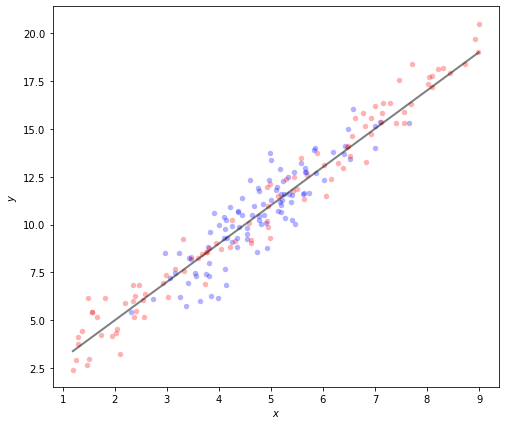

In [8]:
figure(figsize=(8,7))
scatter(xvals_n, yvals_n, s=30, c='b', linewidths=0, alpha=.3)
scatter(xvals_u, yvals_u, s=30, c='r', linewidths=0, alpha=.3)
# True regression line:
xvals = linspace(xvals_u.min(), xvals_u.max(), 3)
yvals = beta_0 + beta_1*xvals
plot(xvals, yvals, 'k-', lw=2, alpha=.5)
xlabel('$x$')
ylabel('$y$')

## Normal marginal case

The following Stan code describes the normal marginal case (i.e., a conditionally-specified bivariate normal); it adopts broad normal priors for the regression coefficients. This code could have been provided in a separate ".stan" file, but for the assignment you should use a code string in the notebook.

*Note that the string here is a __TEMPLATE__ that we fill using Python variables.*

In [9]:
normal_code = """
data {
    int<lower=0> n; // number of samples
    real x[n]; // samples
    real y[n]; // samples
}

parameters {
    real beta_0;
    real beta_1;
}

model {
    beta_0 ~ normal(0, 10.);  // prior is a wide normal
    beta_1 ~ normal(0, 10.);
    for (i in 1:n) {
        x[i] ~ normal(%f, %f);  // normal marginal for x
        y[i] ~ normal(beta_0 + beta_1*x[i], 1.);
    }
}
""" % (mu_x, sig_x)
print(normal_code)


data {
    int<lower=0> n; // number of samples
    real x[n]; // samples
    real y[n]; // samples
}

parameters {
    real beta_0;
    real beta_1;
}

model {
    beta_0 ~ normal(0, 10.);  // prior is a wide normal
    beta_1 ~ normal(0, 10.);
    for (i in 1:n) {
        x[i] ~ normal(5.000000, 1.000000);  // normal marginal for x
        y[i] ~ normal(beta_0 + beta_1*x[i], 1.);
    }
}



Now we use `StanFitter` to compile the model, and fit it to the data generated from the normal marginal case.

When first run, the `StanFitter()` call will take a while, as it compiles the Stan code; progress will be logged to the terminal session where you are running the notebook server. If there is a bug in your Stan code, you may find the **messages printed to the terminal** (not in the notebook) helpful for debugging. Stan supports `print()` statements in Stan code as an aid to debugging; see section 65.7 of the Stan User's Guide for details.

For every run, the fitting (invoked via the fitter's `sample()` method) may take a while (depending on how many samples you compute); it, too, logs progress to the terminal.

You can safely ignore **warnings** produced in either step, but **errors or exceptions** will need attention.

In [10]:
# Invoke Stan to build the model, caching the built model in the CWD to save
# time if the script is re-run without any Stan code changes.
nfitter = StanFitter(normal_code, name='x_normal')

# Stan requires a dictionary providing the data.
normal_data = {'n': n,  'x': xvals_n, 'y': yvals_n}
nfitter.set_data(normal_data)

# Run 4 chains of 5000 iters; Stan keeps the last half of each -> 10k samples.
# The fitter returns a StanFitResults instance, whose attributes provide
# access to the fit results.
n_iter, n_chains = 5000, 4
nfit = nfitter.sample(n_iter, n_chains)

Using cached StanModel from cached-model-x_normal-ec1c9a848f0bdadf497410ed9fabff03.pkl...

Gradient evaluation took 9.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.93 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000205 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.05 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:    1 / 5000 [  0%]  (Warmup)

Gradient evaluation took 0.000113 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.13 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 

`nfit` is a `StanFitResults` instance that has attributes named for each parameter (and a `log_p` attribute for the posterior density) providing access to fit results.  A print command produces a simple textual summary, including diagnostics (*be sure to check these!*) and various posterior summaries (meaningful only if the chains have converged and are mixing well).

In [11]:
print(nfit.beta_0)
print(nfit.beta_1)
print(nfit.log_p)

Parameter <beta_0> summary:
Convergence and mixing diagnostics:  Rhat = 1.00, ESS = 1407
Mean (se), median, sd:  0.543 (0.0131),  0.545,  0.492
Central intvls:  50%: [0.215, 0.868];  95%: [-0.422, 1.5]

Parameter <beta_1> summary:
Convergence and mixing diagnostics:  Rhat = 1.00, ESS = 1434
Mean (se), median, sd:  2.1 (0.00266),  2.1,  0.101
Central intvls:  50%: [2.03, 2.16];  95%: [1.89, 2.29]

Parameter <log_p> summary:
Convergence and mixing diagnostics:  Rhat = 1.00, ESS = 2276
Mean (se), median, sd:  -60.54 (0.02),  -60.22,  1.03
Central intvls:  50%: [-60.95, -59.80];  95%: [-63.29, -59.53]



The `traceplots()` function from `bivar_helpers` accesses the samples to produce a figure with trace plots for all parameters and `log_p`.  Colors distinguish the multiple chains.

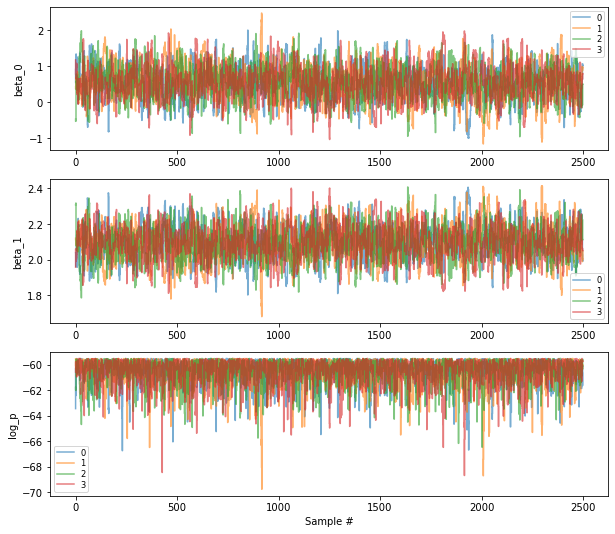

In [12]:
# Check convergence & mixing by examining trace plots.
traceplots(nfit)

The `StanFitResults` instance also provides access to PyStan's default plot, a PyMC plot showing an estimated marginal PDF for each parameter (computed from the samples via a kernel density estimate), and a traceplot produced by merging all chains and shuffling the points (a somewhat questionable practice, as signs of poor convergence and mixing may be hidden).

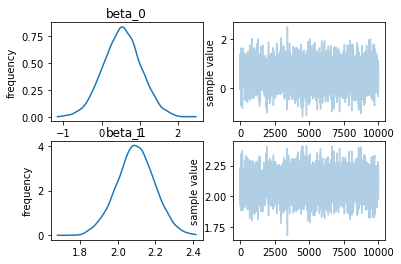

In [13]:
# Stan's default plot, showing a (marginal) PDF (via KDE) and a merged-chains
# trace plot:
fig = nfit.stan_plot()

As the deprecation warning message suggests, `ArviZ` provides better traceplot and marginal density plot capability. Use the `azdata` attribute of `nfit` to provide data to `ArviZ` tools.

array([[<AxesSubplot:title={'center':'beta_0'}>,
        <AxesSubplot:title={'center':'beta_0'}>],
       [<AxesSubplot:title={'center':'beta_1'}>,
        <AxesSubplot:title={'center':'beta_1'}>]], dtype=object)

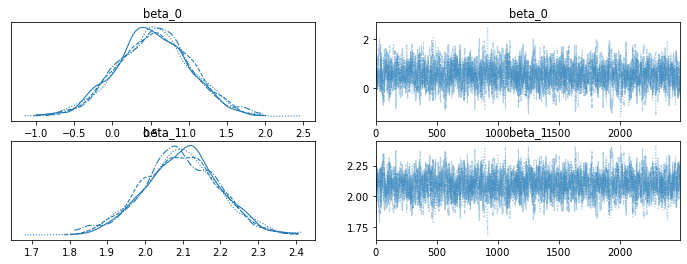

In [14]:
az.plot_trace(nfit.azdata, var_names=('beta_0', 'beta_1'))

array([[<AxesSubplot:title={'center':'beta_0\n0'}>,
        <AxesSubplot:title={'center':'beta_0\n1'}>,
        <AxesSubplot:title={'center':'beta_0\n2'}>,
        <AxesSubplot:title={'center':'beta_0\n3'}>],
       [<AxesSubplot:title={'center':'beta_1\n0'}>,
        <AxesSubplot:title={'center':'beta_1\n1'}>,
        <AxesSubplot:title={'center':'beta_1\n2'}>,
        <AxesSubplot:title={'center':'beta_1\n3'}>]], dtype=object)

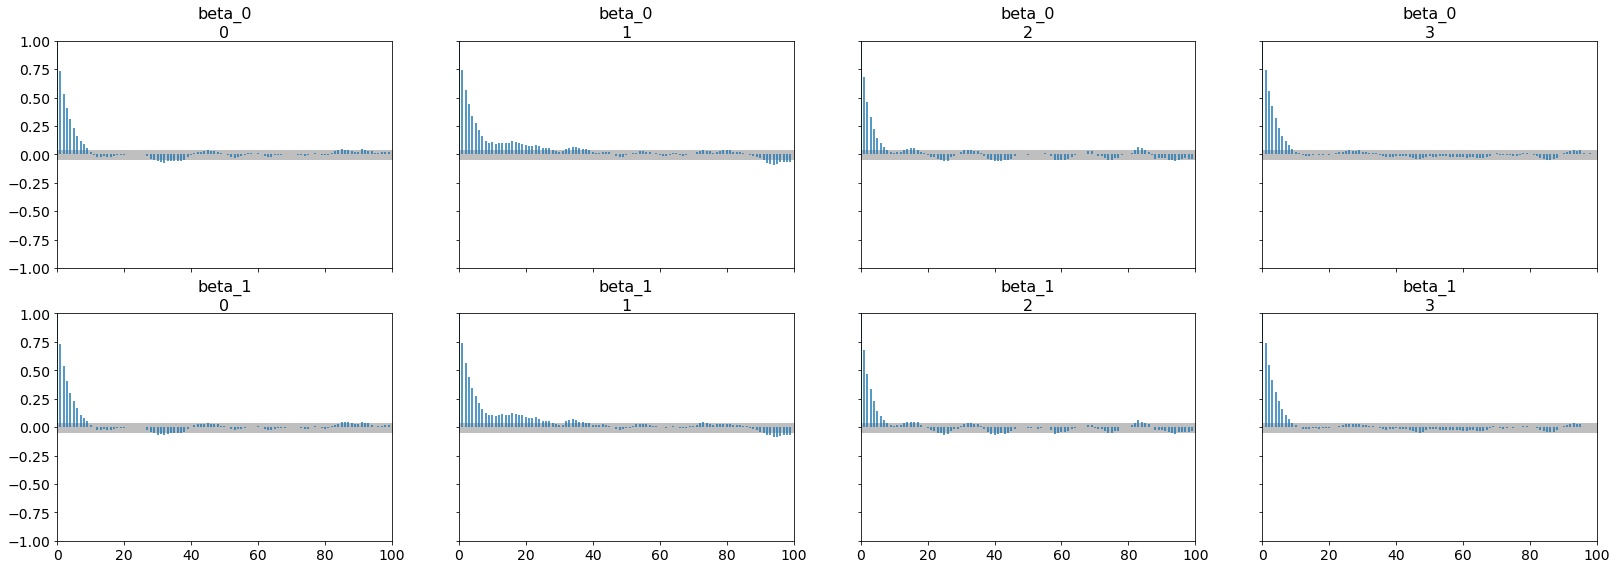

In [15]:
# Autocorrelations, another visual check of mixing:
az.plot_autocorr(nfit.azdata)

Finally, the `betas_plot()` function from `bivar_helpers` produces a scatterplot of the $(\beta_0,\beta_1)$ samples, providing a visual portrayal of the joint posterior PDF. It uses Stan's estimate of the effective sample size (ESS) to thin the Markov chains so that the plotted samples are approximately independent.

Thinning chains by 2


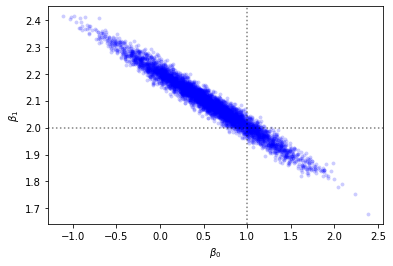

In [16]:
# Plot sample scatterplot displaying the joint posterior.
betas_plot(nfit, beta_0, beta_1)

0.5320093600287266Initial log joint probability = -19084.1
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       3      -59.5103      0.119109   2.12374e-12           1           1        7   
Optimization terminated normally: 
  Convergence detected: gradient norm is below tolerance
 2.0981416580794527


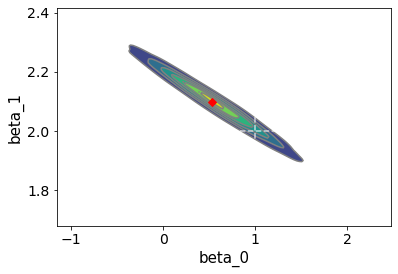

In [17]:
# ArviZ PDF contour plot, with crosshairs.
# Contour levels aren't documented!
ax = az.plot_pair(nfit.azdata, kind='kde')
xhair = dict(c='w', ls='--', lw=1.5, alpha=.7)
ax.axvline(beta_0, **xhair)
ax.axhline(beta_1, **xhair)

# Stan provides an optimizer; StanFitter accesses it via a mode method.
mode = nfitter.mode()
print(mode.beta_0, mode.beta_1)
ax.plot([mode.beta_0], [mode.beta_1], 'rD')

## Uniform marginal case

Now we use PyStan to fit the data generated from the uniform marginal joint distribution, using a model that accurately describes the data generation process. *Be careful about how `Stan` (or any language) parameterizes distributions!* For the uniform distribution, see [Stan Functions Reference 20.1 - Uniform distribution](https://mc-stan.org/docs/2_23/functions-reference/uniform-distribution.html).

In [18]:
uniform_code = """
data {
    int<lower=0> n; // number of samples
    real x[n]; // samples
    real y[n]; // samples
}

parameters {
    real beta_0;
    real beta_1;
}

model {
    beta_0 ~ normal(0, 10.);  // prior is a wide normal
    beta_1 ~ normal(0, 10.);
    for (i in 1:n) {
        x[i] ~ uniform(%f, %f);  // uniform marginal for x
        y[i] ~ normal(beta_0 + beta_1*x[i], 1.);
    }
}
""" % (x_l, x_u)
print(uniform_code)


data {
    int<lower=0> n; // number of samples
    real x[n]; // samples
    real y[n]; // samples
}

parameters {
    real beta_0;
    real beta_1;
}

model {
    beta_0 ~ normal(0, 10.);  // prior is a wide normal
    beta_1 ~ normal(0, 10.);
    for (i in 1:n) {
        x[i] ~ uniform(1.000000, 9.000000);  // uniform marginal for x
        y[i] ~ normal(beta_0 + beta_1*x[i], 1.);
    }
}



In [19]:
# Invoke Stan to build the model, caching the built model in the CWD to save
# time if the script is re-run without any Stan code changes.
ufitter = StanFitter(uniform_code, name='x_uniform')

# Stan requires a dictionary providing the data.
uniform_data = {'n': n,  'x': xvals_u, 'y': yvals_u}
ufitter.set_data(uniform_data)

# Run the same size chains as above.
ufit = ufitter.sample(n_iter, n_chains)

Using cached StanModel from cached-model-x_uniform-a015d36eb5da96eabe2ba3edd23e0443.pkl...

Gradient evaluation took 4.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)

Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 3.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)

Gradient evaluation took 4.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 /

In [20]:
print(ufit.beta_0)
print(ufit.beta_1)
print(ufit.log_p)

Parameter <beta_0> summary:
Convergence and mixing diagnostics:  Rhat = 1.00, ESS = 2189
Mean (se), median, sd:  0.871 (0.00502),  0.868,  0.235
Central intvls:  50%: [0.711, 1.03];  95%: [0.42, 1.34]

Parameter <beta_1> summary:
Convergence and mixing diagnostics:  Rhat = 1.00, ESS = 2233
Mean (se), median, sd:  2.05 (0.000927),  2.05,  0.0438
Central intvls:  50%: [2.02, 2.08];  95%: [1.96, 2.14]

Parameter <log_p> summary:
Convergence and mixing diagnostics:  Rhat = 1.00, ESS = 3281
Mean (se), median, sd:  -36.25 (0.02),  -35.94,  1.01
Central intvls:  50%: [-36.63, -35.53];  95%: [-39.01, -35.26]



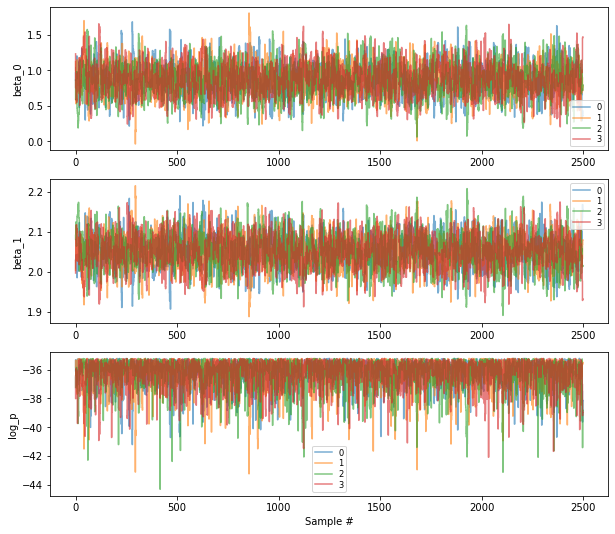

In [21]:
# Check convergence & mixing by examining trace plots.
traceplots(ufit)

array([[<AxesSubplot:title={'center':'beta_0'}>,
        <AxesSubplot:title={'center':'beta_0'}>],
       [<AxesSubplot:title={'center':'beta_1'}>,
        <AxesSubplot:title={'center':'beta_1'}>]], dtype=object)

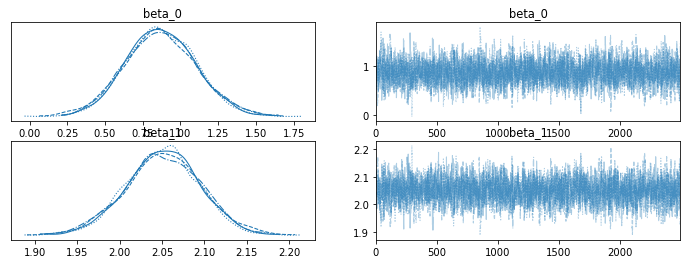

In [22]:
# Same via ArviZ, but useful to see the marginals.
az.plot_trace(ufit.azdata)

Thinning chains by 2


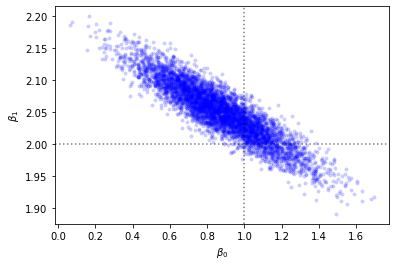

In [23]:
# Plot sample scatterplot displaying the joint posterior.
betas_plot(ufit, beta_0, beta_1)

Initial log joint probability = -1557.32
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


       3      -35.2298      0.550469   3.39377e-14           1           1        7   
Optimization terminated normally: 
  Convergence detected: gradient norm is below tolerance


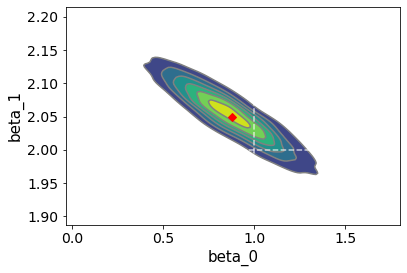

In [24]:
ax = az.plot_pair(ufit.azdata, kind='kde')
ax.axvline(beta_0, **xhair)
ax.axhline(beta_1, **xhair)
mode = ufitter.mode()
ax.plot([mode.beta_0], [mode.beta_1], 'rD')

## Model misspecification and conditional independence

When the model adopted to analyze a dataset does not accurately describe the data generation process, one says the model is *misspecified*. One should of course always try to model the data as accurately as possible, but truly accurate modeling is often impossible with real-world data. The influence of model misspecification on inferences can be dramatic or subtle, sometimes in surprising ways.

### Normal marginal model fit to uniform marginal data

Let's use the **normal marginal model** (provided above in `nfitter`) **to fit the uniform marginal data**.

In [25]:
nfitter.set_data(uniform_data)
nfit_udata = nfitter.sample(n_iter, n_chains)


Gradient evaluation took 6.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)

Gradient evaluation took 7.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.74 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:    1 / 5000 [  0%]  (Warmup)

Gradient evaluation took 8.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.86 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration: 1000 / 5000 [ 20%

In [26]:
print(nfit_udata.beta_0)
print(nfit_udata.beta_1)
print(nfit_udata.log_p)

Parameter <beta_0> summary:
Convergence and mixing diagnostics:  Rhat = 1.00, ESS = 2100
Mean (se), median, sd:  0.878 (0.0051),  0.877,  0.234
Central intvls:  50%: [0.723, 1.04];  95%: [0.415, 1.34]

Parameter <beta_1> summary:
Convergence and mixing diagnostics:  Rhat = 1.00, ESS = 2122
Mean (se), median, sd:  2.05 (0.000951),  2.05,  0.0438
Central intvls:  50%: [2.02, 2.08];  95%: [1.96, 2.14]

Parameter <log_p> summary:
Convergence and mixing diagnostics:  Rhat = 1.00, ESS = 3512
Mean (se), median, sd:  -36.26 (0.02),  -35.93,  1.04
Central intvls:  50%: [-36.66, -35.52];  95%: [-39.05, -35.25]



array([[<AxesSubplot:title={'center':'beta_0'}>,
        <AxesSubplot:title={'center':'beta_0'}>],
       [<AxesSubplot:title={'center':'beta_1'}>,
        <AxesSubplot:title={'center':'beta_1'}>]], dtype=object)

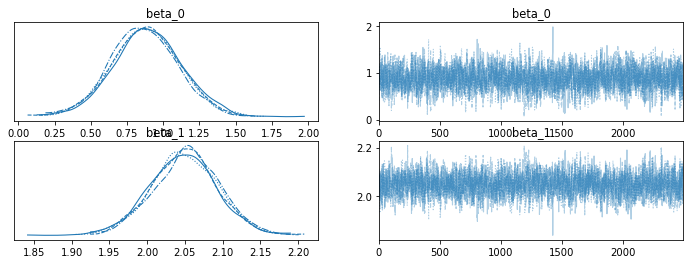

In [27]:
az.plot_trace(nfit_udata.azdata)

array([[<AxesSubplot:title={'center':'beta_0'}>,
        <AxesSubplot:title={'center':'beta_0'}>],
       [<AxesSubplot:title={'center':'beta_1'}>,
        <AxesSubplot:title={'center':'beta_1'}>]], dtype=object)

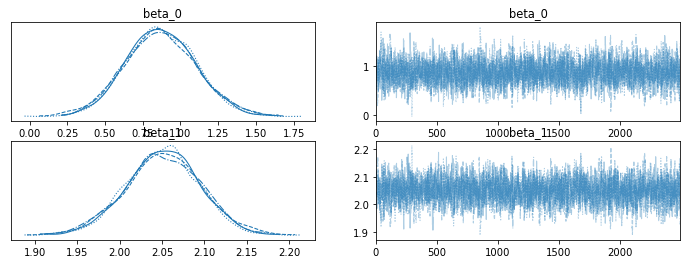

In [28]:
# For comparison, repeat the marginals from the well-specified fit to these data.
az.plot_trace(ufit.azdata)

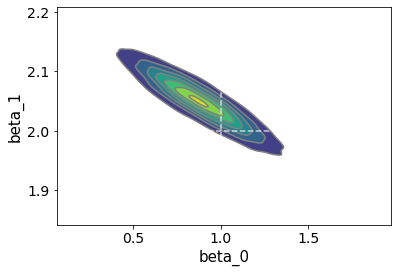

In [29]:
ax = az.plot_pair(nfit_udata.azdata, kind='kde')
ax.axvline(beta_0, **xhair)
ax.axhline(beta_1, **xhair)

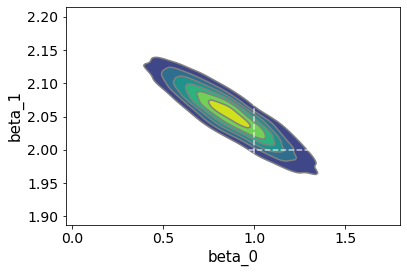

In [30]:
# For comparison, show the well-specified fit results.
ax = az.plot_pair(ufit.azdata, kind='kde')
ax.axvline(beta_0, **xhair)
ax.axhline(beta_1, **xhair)

Compare the results using the well-specified vs. misspecified models. Do the results look significantly different or substantially the same? Why? _**Hint:**_ See Lec18, slide 10.

## Stan's vector & matrix support

See the assignment for tips about formulating regression using vectors of coefficients and a design matrix. Here we just quickly present an example duplicating the normal marginal analysis above using Stan's vector & matrix support.

In [31]:
vec_normal_code = """
data {
    int<lower=0> n; // number of samples
    real x[n]; // samples
    real y[n]; // samples

    int<lower=0> m; // number of coefficients
    matrix[n,m] basis; // basis funcs, aka design matrix
}

parameters {
    vector[m] beta;  // coeficients
}

model {
    beta[1] ~ normal(0, 10.);  // prior is a wide normal
    beta[2] ~ normal(0, 10.);
    x ~ normal(%f, %f);  // normal marginal for x
    y ~ normal(basis * beta, 1.);
}
""" % (mu_x, sig_x)
print(vec_normal_code)


data {
    int<lower=0> n; // number of samples
    real x[n]; // samples
    real y[n]; // samples

    int<lower=0> m; // number of coefficients
    matrix[n,m] basis; // basis funcs, aka design matrix
}

parameters {
    vector[m] beta;  // coeficients
}

model {
    beta[1] ~ normal(0, 10.);  // prior is a wide normal
    beta[2] ~ normal(0, 10.);
    x ~ normal(5.000000, 1.000000);  // normal marginal for x
    y ~ normal(basis * beta, 1.);
}



In [32]:
vnfitter = StanFitter(vec_normal_code, name='vec_x_normal')

Using cached StanModel from cached-model-vec_x_normal-ac512c0122ab2507f4f9f54acb62e279.pkl...


In [33]:
# Design matrix has rows indexing data cases, cols indexing basis functions.
basis = ones((n,2))

# Basis function for the intercept is just 1's, so we leave col=0 as-is.

# Basis function for the linear term is just the data x values:
basis[:,1] = xvals_n

In [34]:
vec_normal_data = {'n': n,  'x': xvals_n, 'y': yvals_n,
                   'm': 2, 'basis': basis}
vnfitter.set_data(vec_normal_data)
vnfit = vnfitter.sample(n_iter, n_chains)


Gradient evaluation took 0.000174 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.74 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)

Gradient evaluation took 0.000115 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.9 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:    1 / 5000 [  0%]  (Warmup)

Gradient evaluation took 8.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.81 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration: 1000 / 5000 [ 20%]

In [35]:
print(vnfit.beta[0])
print(vnfit.beta[1])

Parameter <beta[1]> summary:
Convergence and mixing diagnostics:  Rhat = 1.00, ESS = 1607
Mean (se), median, sd:  0.535 (0.012),  0.536,  0.48
Central intvls:  50%: [0.212, 0.857];  95%: [-0.405, 1.5]

Parameter <beta[2]> summary:
Convergence and mixing diagnostics:  Rhat = 1.00, ESS = 1619
Mean (se), median, sd:  2.1 (0.00243),  2.1,  0.0978
Central intvls:  50%: [2.03, 2.16];  95%: [1.9, 2.29]



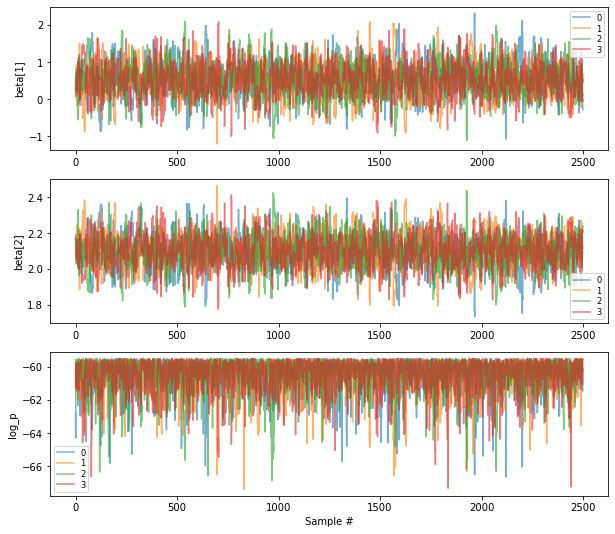

In [36]:
traceplots(vnfit, vector=True)

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

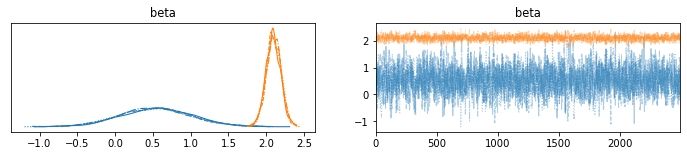

In [37]:
# Note: ArviZ's support of vector params appears broken at the moment.
az.plot_trace(vnfit.azdata)

Thinning chains by 2


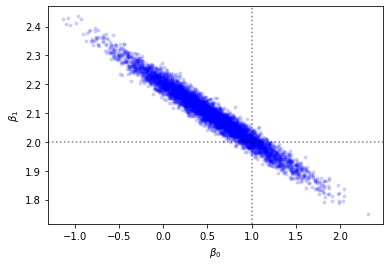

In [38]:
betas_plot(vnfit, beta_0, beta_1, vector=True)